# Regularization

In [1]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression,\
LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold,\
cross_val_score, cross_validate, ShuffleSplit
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Objectives

- Explain the notion of "validation data"
- Use the algorithm of cross-validation (with `sklearn`)
- Explain the concept of regularization
- Use Lasso and Ridge regularization in model design

One of the goals of a machine learning project is to make models which are highly predictive.
If the model fails to generalize to unseen data then the model is bad.

# When a Good Model Goes Bad

> One of the goals of a machine learning project is to make models which are highly predictive

Adding complexity to a model can find patterns to help make better predictions! 

But too much complexity can lead to the model finding patterns in the noise...

![Overfitting Model](images/overfitting_model_meme.jpeg)

>So how do we know when our model is ~~a conspiracy theorist~~ overfitting?

## Bias-Variance Tradeoff

1. High bias
    1. Systematic error in predictions
    2. Bias is about the strength of assumptions the model makes
    3. Underfit models tend to have high bias
2. High variance
    1. The model is highly sensitive to changes in the data
    2. Overfit models tend to have low bias

![](images/bias_vs_variance.png)

##### Aside: Example of high bias and variance

High bias is easy to wrap one's mind around: Imagine pulling three red balls from an urn that has hundreds of balls of all colors in a uniform distribution. Then my sample is a terrible representative of the whole population. If I were to build a model by extrapolating from my sample, that model would predict that _every_ ball produced would be red! That is, this model would be incredibly biased.

High variance is a little bit harder to visualize, but it's basically the "opposite" of this. Imagine that the population of balls in the urn is mostly red, but also that there are a few balls of other colors floating around. Now imagine that our sample comprises a few balls, none of which is red. In this case, we've essentially picked up on the "noise", rather than the "signal". If I were to build a model by extrapolating from my sample, that model would be needlessly complex. It might predict that balls drawn before noon will be orange and that balls drawn after 8pm will be green, when the reality is that a simple model that predicted 'red' for all balls would be a superior model!

The important idea here is that there is a *trade-off*: If we have too few data in our sample (training set), or too few predictors, we run the risk of high *bias*, i.e. an underfit model. On the other hand, if we have too many predictors (especially ones that are collinear), we run the risk of high *variance*, i.e. an overfit model.

[Here](https://en.wikipedia.org/wiki/Overfitting#/media/File:Overfitting.svg) is a nice illustration of the difficulty.

### Underfitting

> Underfit models fail to capture all of the information in the data

* low complexity --> high bias, low variance
* training error: large
* testing error: large

### Overfitting

> Overfit models fit to the noise in the data and fail to generalize

* high complexity --> low bias, high variance
* training error: low
* testing error: large

## How Do We Identify a Bad Model? 🕵️

### Solution - Model Validation

Generally speaking we want to take more precautions than using just a test and train split. After all, we're still imagining building just one model on the training set and then crossing our fingers for its performance on the test set.

Data scientists often distinguish *three* subsets of data: **training, validation (dev), and testing**

Roughly:
- Training data is for building the model;
- Validation data is for *tweaking* the model;
- Testing data is for evaluating the model on unseen data.

- Think of **training** data as what you study for a test
- Think of **validation** data is using a practice test (note sometimes called **dev**)
- Think of **testing** data as what you use to judge the model
    - A **holdout** set is when your test dataset is never used for training (unlike in cross-validation)

![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)
> Image from Scikit-Learn https://scikit-learn.org/stable/modules/cross_validation.html

### Steps:

1. Split data into training data and a holdout test
2. Design a model
3. Evaluate how well it generalizes with **cross-validation** (only training data)
4. Determine if we should adjust model, use cross-validation to evaluate, and repeat
5. After iteratively adjusting your model, do a _final_ evaluation with the holdout test set
6. DON'T TOUCH THE MODEL!!!

### The Power of the Validation Set

This "tweaking" includes most of all the fine-tuning of model parameters (see below). Think of what this three-way distinction allows us to do:

I can build a model on some data. Then, **before** I introduce the model to the testing data, I can introduce it to a different batch of data (the validation set). With respect to the validation data I can do things like measure error and tweak model parameters to minimize that error. Of course, I also don't want to lose sight of the error on the training data. If the model error has been minimized on the training error, then of course any changes I make to the model parameters will take me away from that minimum. But still the new information I've gained by looking at the model's performance on the validation data is valuable. I might for example go with a kind of compromising model whose parameters produce an error that's not too big on the training data and not too big on the validation data.

**Question**: What's different about this procedure from what we've described before? Aren't I just calling the test data "validation data" now? Is there any substantive difference?

#### From Validation to Cross-Validation

Since my model will "see" the validation data in any case, I might as well use *all* of my training data to validate my model! How do I do this?

Cross-validation works like this: First I'll partition my training data into $k$-many *folds*. Then I'll train a model on $k-1$ of those folds and "test" it on the remaining fold. I'll do this for all possible divisions of my $k$ folds into $k-1$ training folds and a single "testing" fold. Since there are $k\choose 1$$=k$-many ways of doing this, I'll be building $k$-many models!

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

##### Python Example

In [2]:
birds = sns.load_dataset('penguins')
birds.sample(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
76,Adelie,Torgersen,40.9,16.8,191.0,3700.0,Female
271,Gentoo,Biscoe,48.5,14.1,220.0,5300.0,Male
80,Adelie,Torgersen,34.6,17.2,189.0,3200.0,Female
99,Adelie,Dream,43.2,18.5,192.0,4100.0,Male


In [3]:
birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
# For simplicity's sake we'll limit our analysis to the numeric columns.
# Newer versions of seaborn have "bill" instead of "culmen".

numeric = birds[['bill_length_mm', 'bill_depth_mm',
                 'flipper_length_mm', 'body_mass_g']]

In [5]:
# We'll drop the rows with null values

numeric = numeric.dropna().reset_index()

Suppose I want to model `body_mass_g` as a function of the other attributes.

In [6]:
X = numeric.drop('body_mass_g', axis=1)
y = numeric['body_mass_g']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##### We'll do 10-fold cross validation

In [9]:
lr2 = LinearRegression()

In [12]:
cv_results = cross_validate(estimator = lr2, X=X_train, y = y_train, cv = 5, scoring = ['r2', 'neg_mean_squared_error'], return_train_score=True)

In [13]:
type(cv_results)

dict

In [14]:
cv_results

{'fit_time': array([0.00597286, 0.00315094, 0.00201297, 0.00208998, 0.00193906]),
 'score_time': array([0.00487614, 0.00192809, 0.00145507, 0.00149393, 0.00163794]),
 'test_r2': array([0.71894444, 0.72700005, 0.80643983, 0.70431316, 0.68589904]),
 'train_r2': array([0.74438281, 0.74445074, 0.72477685, 0.74767406, 0.74916123]),
 'test_neg_mean_squared_error': array([-139307.18994093, -200661.39500078, -116398.2354425 ,
        -186520.59181429, -192758.63502496]),
 'train_neg_mean_squared_error': array([-165948.40078555, -150405.08380363, -171050.5976784 ,
        -154718.86834392, -154721.80687727])}

In [17]:
cv_results.get('train_r2')

array([0.74438281, 0.74445074, 0.72477685, 0.74767406, 0.74916123])

In [18]:
cv_results.get('test_r2')

array([0.71894444, 0.72700005, 0.80643983, 0.70431316, 0.68589904])

In [15]:
# Compare the results
print(-1*cv_results.get('train_neg_mean_squared_error').mean(),
      cv_results.get('train_neg_mean_squared_error').std())

159368.95149775344 7788.711843681345


In [16]:
print(-1*cv_results.get('test_neg_mean_squared_error').mean(),
      cv_results.get('test_neg_mean_squared_error').std())

167129.20944469268 33181.31138585449


In [19]:
lr2.fit(X_train, y_train)

LinearRegression()

In [20]:
lr2.score(X_train, y_train)

0.7409035352797058

# Preventing Overfitting - Regularization

Again, complex models are very flexible in the patterns that they can model but this also means that they can easily find patterns that are simply statistical flukes of one particular dataset rather than patterns reflective of the underlying data-generating process.

When a model has large weights, the model is "too confident". This translates to a model with high variance which puts it in danger of overfitting!

![](images/punishing_model_metaphor.jpeg)

We need to punish large (confident) weights by factoring them in to the error function

**Some Types of Regularization:**

1. Reducing the number of features
2. Increasing the amount of data
3. Popular techniques: Ridge, Lasso, Elastic Net
        

## The Strategy Behind Ridge / Lasso / Elastic Net

Overfit models overestimate the relevance that predictors have for a target. Thus overfit models tend to have **overly large coefficients**. 

Generally, overfitting models come from a result of high model variance. High model variance can be caused by:

- having irrelevant or too many predictors
- multicollinearity
- large coefficients

The evaluation of many models, linear regression included, proceeds by measuring its **error**, some quantifiable expression of the discrepancy between its predictions and the ground truth. The best-fit line of LR, for example, minimizes the sum of squared residuals.

Our new idea, then, will be ***to add a term representing the size of our coefficients to our loss function***. This will be our **cost function** $J$.

The goal will still be to minimize this new function, but we can make progress toward this minimum *either* by reducing the size of our residuals *or* by reducing the size of our coefficients.

Since coefficients can be either negative or positive, we have the familiar difficulty that we can't simply add them up to get a sense of how large they are in general. Once again there are two natural choices: We could focus either on the squares or the absolute values of the coefficients. The former strategy is the basis for **Ridge** (also called Tikhonov) regularization; the latter strategy results in **Lasso** (Least Absolute Shrinkage and Selection Operator) regularization.

These tools, as we shall see, are easily implemented with `sklearn`.

--------

## Ridge and Lasso Regression

The first problem is about picking up on noise rather than signal.
The second problem is about having a least-squares estimate that is highly sensitive to random error.
The third is about having highly sensitive predictors.

Regularization is about introducing a factor into our model designed to enforce the stricture that the coefficients stay small, by penalizing the ones that get too large.

That is, we'll alter our loss function so that the goal now is not merely to minimize the difference between actual values and our model's predicted values. Rather, we'll add in a term to our loss function that represents the sizes of the coefficients.

### Lasso: L1 Regularization - Absolute Value

- Tend to get sparse vectors (small weights go to 0)
- Reduce number of weights
- Good feature selection to pick out importance

$$ J(W,b) = -\dfrac{1}{m} \sum^m_{i=1}\big[\mathcal{L}(\hat y_i, y_i)+ \lambda|w_i| \big]$$

### Ridge: L2 Regularization - Squared Value

- Not sparse vectors (weights homogeneous & small)
- Tends to give better results for training

    
$$ J(W,b) = -\dfrac{1}{m} \sum^m_{i=1}\big[\mathcal{L}(\hat y_i, y_i)+ \lambda w_i^2 \big]$$

### 🤔 Which Do I Use?

> Typically you'll want to use L2 regularization 

- For a given value of $\lambda$, the ridge makes for a gentler reining in of runaway coefficients. When in doubt, try ridge first.
- The lasso will more quickly reduce the contribution of individual predictors down to insignificance. It is therefore most useful for trimming through the fat of datasets with many predictors or if a model with very few predictors is especially desirable.

##### Aside: Comparing L1 & L2 Regularization

This is a bit subtle: 
- Consider vectors: [1,0] & [0.5, 0.5] 
- Recall we want smallest value for our value
- L2 prefers [0.5,0.5] over [1,0] 

For a nice discussion of these methods in Python, see [this post](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b).

### The Best of Both Worlds: Elastic Net

There is a combination of L1 and L2 regularization called the Elastic Net that can also be used. The idea is to use a scaled linear combination of the lasso and the ridge, where the weights add up to 100%. We might want 50% of each, but we also might want, say, 10% Lasso and 90% Ridge.

The loss function for an Elastic Net Regression looks like this:

Elastic Net:

$\rho\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}|\beta_j|] + (1 - \rho)\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}\beta^2_j]$

Sometimes you will see this loss function represented with different scaling terms, but the basic idea is to have a combination of L1 and L2 regularization terms.

## Code it Out!

### Producing an Overfit Model

We can often produce an overfit model by including **interaction terms**. We'll start over with the penguins dataset. This time we'll include the categorical features.

#### Train-Test Split

In [21]:
birds = sns.load_dataset('penguins')
birds = birds.dropna()

In [22]:
birds.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
                                        birds.drop('body_mass_g', axis=1),
                                        birds['body_mass_g'],
                                        random_state=42
)

In [24]:
# Taking in other features (category)
ohe = OneHotEncoder(drop='first')
dummies = ohe.fit_transform(X_train[['species', 'island', 'sex']])

# Getting a DF
dummies_df = pd.DataFrame(dummies.todense(), columns=ohe.get_feature_names(),
                         index=X_train.index)

# What we'll feed int our model
X_train_df = pd.concat([X_train[['bill_length_mm', 'bill_depth_mm',
                                'flipper_length_mm']], dummies_df], axis=1)
X_train_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,x0_Chinstrap,x0_Gentoo,x1_Dream,x1_Torgersen,x2_Male
321,55.9,17.0,228.0,0.0,1.0,0.0,0.0,1.0
265,43.6,13.9,217.0,0.0,1.0,0.0,0.0,0.0
36,38.8,20.0,190.0,0.0,0.0,1.0,0.0,1.0
308,47.5,14.0,212.0,0.0,1.0,0.0,0.0,0.0
191,53.5,19.9,205.0,1.0,0.0,1.0,0.0,1.0


Our Test Data:

In [25]:
# Note the same transformation (not FIT) to match structure
test_dummies = ohe.transform(X_test[['species', 'island', 'sex']])
test_df = pd.DataFrame(test_dummies.todense(), columns=ohe.get_feature_names(),
                       index=X_test.index)
X_test_df = pd.concat([X_test[['bill_length_mm', 'bill_depth_mm',
                              'flipper_length_mm']], test_df], axis=1)

#### First model

In [26]:
lr = LinearRegression()
lr.fit(X_train_df, y_train)

LinearRegression()

In [27]:
lr.score(X_train_df, y_train)

0.8688983108974327

Let's do some cross-validation!

In [28]:
cv_results = cross_validate(X=X_train_df, y=y_train, estimator=lr, cv=5, scoring=['r2','neg_mean_squared_error'], return_train_score=True)

In [29]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error'])

In [30]:
train_res = cv_results['train_r2']
train_res

array([0.87258013, 0.86632657, 0.86663355, 0.875189  , 0.8713504 ])

In [31]:
valid_res = cv_results['test_r2']
valid_res

array([0.83237827, 0.86679141, 0.87466291, 0.83416564, 0.84514955])

#### Add Polynomial Features

In [32]:
pf = PolynomialFeatures(degree=3)
X_poly_train = pf.fit_transform(X_train_df)

In [33]:
X_poly_test = pf.transform(X_test_df)

Train the model and evaluate (with cross-validation)

In [34]:
poly_lr = LinearRegression()
poly_lr.fit(X_poly_train, y_train)

LinearRegression()

In [35]:
poly_lr.score(X_poly_train, y_train)

0.8929837784586662

In [36]:
cv_results = cross_validate(
                X=X_poly_train, 
                y=y_train,
                estimator=poly_lr, 
                cv=10,
                scoring=('r2', 'neg_mean_squared_error'),
                return_train_score=True
)

In [37]:
train_res = cv_results['train_r2']
train_res

array([0.81274492, 0.90586698, 0.8712184 , 0.86791377, 0.87630337,
       0.89249437, 0.87772829, 0.89532594, 0.91414692, 0.80533058])

In [38]:
valid_res = cv_results['test_r2']
valid_res

array([ 0.58415864, -0.98182009,  0.5788367 ,  0.67200787,  0.13603451,
        0.51348532,  0.11073337,  0.17470135,  0.81904846,  0.56611475])

### Ridge (L2) Regression

In [39]:
ss = StandardScaler()
pf = PolynomialFeatures(degree=3)

# You should always be sure to _standardize_ your data before
# applying regularization!

X_train_processed = ss.fit_transform(pf.fit_transform(X_train_df))
X_test_processed = ss.transform(pf.transform(X_test_df))

In [40]:
lr_over = LinearRegression()
lr_over.fit(X_train_processed, y_train)
lr_over.score(X_train_processed, y_train)

0.8765052897922647

In [41]:
cross_val_score(lr_over, X_train_processed, y_train)

array([ 0.26964248, -1.42272752,  0.51665663, -0.14605675,  0.17662094])

In [46]:
# 'Lambda' is the standard variable for the strength of the
# regularization (as in the above formulas), but since lambda
# is a key word in Python, these sklearn regularization tools
# use 'alpha' instead.

rr = Ridge(alpha=100, random_state=42)

rr.fit(X_train_processed, y_train)

Ridge(alpha=100, random_state=42)

In [47]:
rr.score(X_train_processed, y_train)

0.8779959660236704

In [49]:
cv_results = cross_validate(estimator = rr, X = X_train_processed, y = y_train, return_train_score = True, scoring=['r2', 'neg_mean_squared_error'])

In [50]:
cv_results['train_r2']

array([0.8830529 , 0.87444476, 0.87893131, 0.87946355, 0.87793446])

In [51]:
cv_results['test_r2']

array([0.84367158, 0.87427966, 0.86698197, 0.86293128, 0.85147986])

In [53]:
cv_results['test_r2'].mean()

0.8598688706649551

In [54]:
rr.coef_

array([  0.        ,  17.44523238,  -4.45055857,  36.05263908,
        -1.66234612,  31.44972239,  -2.85831978,   0.3346665 ,
        17.88003171,  12.58997788,   8.99929726,  24.59505937,
        -3.90403185,  28.15157126,  -3.89613504,  -0.70926875,
        11.71712564,  -3.16833619,  19.61017631,  -0.74478461,
        30.49170879,  -1.14946962,   0.10962052,  16.80368655,
        34.67414145,  -0.10564885,  30.25296601,  -1.5367463 ,
        -1.62213062,  17.18467182,  -1.66234612,   0.        ,
        -1.66234612,   0.        , -17.81397136,  31.44972239,
         0.        ,   0.        ,   2.55795215,  -2.85831978,
         0.        ,   6.11383003,   0.3346665 ,  -1.78809681,
        17.88003171,   7.59528742,   8.15118216,  16.93640922,
        -5.98727772,  24.26504558,  -5.40816162,  -1.65687232,
         5.28712646,   3.99606686,  20.21252675,  -2.89402422,
        26.64129127,  -2.35078538,  -0.91777895,  10.89502043,
        26.44390416,  -2.09271358,  26.6824834 ,  -2.30

In [55]:
lr_over.coef_

array([ 4.24175106e+15, -1.47138397e+05,  1.12381747e+05,  7.72256069e+04,
        2.09425070e+04, -4.74958632e+03, -3.21938286e+04, -2.00586729e+04,
       -1.64500644e+02, -1.48829313e+05,  2.19516162e+05,  3.45731943e+05,
        5.40917373e+04,  1.46157698e+05,  2.09101714e+03,  7.25853780e+03,
       -1.46676204e+04, -3.33945353e+05, -6.84940295e+03, -6.30701514e+04,
       -1.97681887e+05,  2.50996612e+04,  8.44897138e+03, -3.28484308e+03,
       -2.89839506e+05, -7.00040847e+04,  1.09746872e+05,  7.07670904e+04,
        4.44367740e+04,  1.64166658e+04,  2.09425070e+04,  2.73981641e-07,
        2.09425070e+04,  6.95763447e-09, -6.62965457e+02, -4.74958632e+03,
       -1.71712600e-08, -1.39152689e-08, -9.97956866e+02, -3.21938286e+04,
       -5.64614311e-09,  1.35164512e+03, -2.00586729e+04,  1.14833356e+03,
       -1.64500643e+02,  4.29309844e+04, -2.03698284e+04,  1.50043815e+05,
       -8.91304726e+04, -1.14207519e+05, -3.37741806e+03, -2.08107280e+04,
       -4.20587400e+04, -

In [56]:
cross_val_score(las, X_train_processed, y_train)

NameError: name 'las' is not defined

Much better! But how do we know which value of `alpha` to pick?

### Optimizing the Regularization Hyperparameter

The regularization strength could sensibly be any nonnegative number, so there's no way to check "all possible" values. It's often useful to try several values that are different orders of magnitude.

In [57]:
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10_000]
train_scores = []
test_scores = []

for alpha in alphas:
    rr = Ridge(alpha=alpha, random_state=42)
    rr.fit(X_train_processed, y_train)
    train_score = rr.score(X_train_processed, y_train)
    test_score = rr.score(X_test_processed, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)

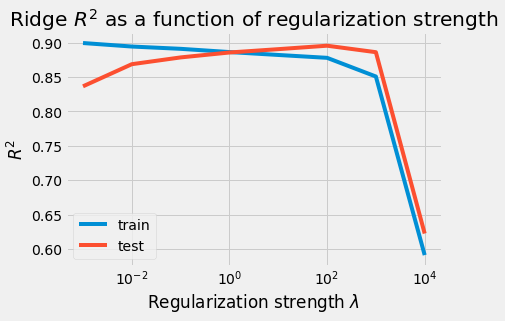

In [58]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.xscale('log')
plt.title('Ridge $R^2$ as a function of regularization strength')
ax.set_xlabel('Regularization strength $\lambda$')
ax.set_ylabel('$R^2$')
ax.plot(alphas, train_scores, label='train')
ax.plot(alphas, test_scores, label='test')
plt.legend();

#### Observation

Notice how the values increase but then decrease? Regularization helps with overfitting, but if the strength of the regularization becomes too great, then large coefficients will be punished more than they really should. What happens then is that the original error between truth and model predictions becomes neglected as a quantity to be minimized, and the bias of the model begins to outweigh its variance.

It looks like the best value is somewhere around 100. If we wanted more precision, we could repeat the same sort of exercise with a set of alphas nearer to 100.

#### Cross-Validation

In [59]:
alphas = [1e-3, 1e-2, 1e-1, 1]
cv_scores = []

for alpha in alphas:
    rr = Ridge(alpha=alpha, random_state=42)
    cv_results = cross_validate(
                X=X_train_df, 
                y=y_train,
                estimator=rr, 
                cv=10,
                scoring=('neg_mean_squared_error'))
    cv_scores.append(-np.mean(cv_results['test_score']))

cv_scores

[93607.97327696784, 93600.69647127388, 93544.25644511318, 93908.58764775092]

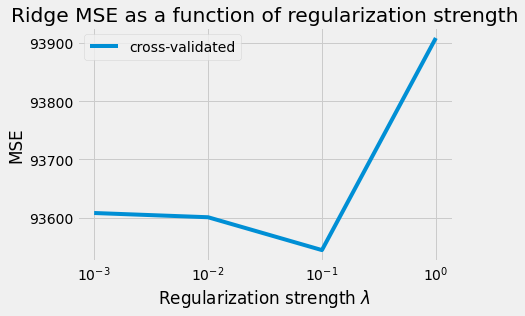

In [60]:
fig, ax = plt.subplots()
plt.xscale('log')
plt.title('Ridge MSE as a function of regularization strength')
ax.set_xlabel('Regularization strength $\lambda$')
ax.set_ylabel('MSE')
ax.plot(alphas, cv_scores, label='cross-validated')
plt.legend();

### LEVEL UP - Elastic Net!

Naturally, the Elastic Net has the same interface through sklearn as the other regularization tools! The only difference is that we now have to specify how much of each regularization term we want. The name of the parameter for this (represented by $\rho$ above) in sklearn is `l1_ratio`.

In [61]:
enet = ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

enet.fit(X_train_processed, y_train)

ElasticNet(alpha=10, l1_ratio=0.1, random_state=42)

In [62]:
enet.score(X_train_processed, y_train)

0.8126996671227142

In [63]:
enet.score(X_test_processed, y_test)

0.8521461762036051

Setting the `l1_ratio` to 1 is equivalent to the lasso:

In [64]:
ratios = np.linspace(0.01, 1, 100)

In [65]:
preds = []
for ratio in ratios:
    enet = ElasticNet(alpha=100, l1_ratio=ratio, random_state=42)
    enet.fit(X_train_processed, y_train)
    preds.append(enet.predict(X_test_processed[0].reshape(1, -1)))

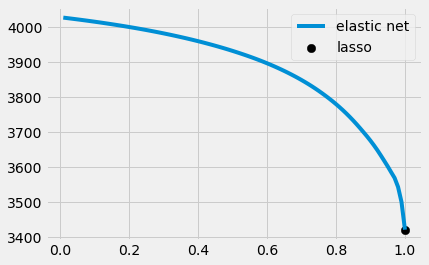

In [66]:
fig, ax = plt.subplots()

lasso = Lasso(alpha=100, random_state=42)
lasso.fit(X_train_processed, y_train)
lasso_pred = lasso.predict(X_test_processed[0].reshape(1, -1))

ax.plot(ratios, preds, label='elastic net')
ax.scatter(1, lasso_pred, c='k', s=70, label='lasso')
plt.legend();

#### Note on `ElasticNet()`

Is an Elastic Net with `l1_ratio` set to 0 equivalent to the ridge? In theory yes. But in practice no. It looks like the `ElasticNet()` predictions on the first test data point as `l1_ratio` shrinks are tending toward some value around 3400. Let's check to see what prediction `Ridge()` gives us:

In [67]:
ridge = Ridge(alpha=10, random_state=42)
ridge.fit(X_train_processed, y_train)
ridge.predict(X_test_processed[0].reshape(1, -1))[0]

3170.81086504222

If you check the docstring for the `ElasticNet()` class you will see:
- that the function being minimized is slightly different from what we saw above; and
- that the results are unreliable when `l1_ratio` $\leq 0.01$.

**Exercise**: Visualize the difference in this case between `ElasticNet(l1_ratio=0.01)` and `Ridge()` by making a scatterplot of each model's predicted values for the first ten points in `X_test_processed`. Use `alpha=10` for each model.

        Level Up: Make a second scatterplot that compares the predictions on the same data
        points between ElasticNet(l1_ratio=1) and Lasso().

<details>
    <summary> Answer
    </summary>
    <code>fig, ax = plt.subplots()
enet_r = ElasticNet(alpha=10, l1_ratio=0.01, random_state=42)
enet_r.fit(X_train_processed, y_train)
preds_enr = enet_r.predict(X_test_processed[:10])
preds_ridge = ridge.predict(X_test_processed[:10])
ax.scatter(np.arange(10), preds_enr)
ax.scatter(np.arange(10), preds_ridge);</code>  
        </details>

<details>
    <summary>
        Level Up
    </summary>
<code>fig, ax = plt.subplots()
enet_l = ElasticNet(alpha=10, l1_ratio=1, random_state=42)
enet_l.fit(X_train_processed, y_train)
preds_enl = enet_l.predict(X_test_processed[:10])
preds_lasso = lasso.predict(X_test_processed[:10])
ax.scatter(np.arange(10), preds_enl)
ax.scatter(np.arange(10), preds_lasso);</code>
    </details

#### Fitting Regularized Models with Cross-Validation

Our friend `sklearn` also includes tools that fit regularized regressions *with cross-validation*: `LassoCV`, `RidgeCV`, and `ElasticNetCV`.

**Exercise**: Use `RidgeCV` to fit a seven-fold cross-validated ridge regression model to our `X_train_processed` data and then calculate $R^2$ and the RMSE (root-mean-squared error) on our test set.

<details>
    <summary>
        Answer
    </summary>
    <code>rcv = RidgeCV(cv=7)
rcv.fit(X_train_processed, y_train)
rcv.score(X_test_processed, y_test)
np.sqrt(mean_squared_error(y_test, rcv.predict(X_test_processed)))</code>
    </details>